# Evaluation of MobileNet V2 and ResNet-18 using CIFAR-100
In this notebook, we will evaluate two distinct architectures MobileNetV2 (optimized for efficiency) and ResNet-18 (optimized for feature extraction accuracy) on the CIFAR-100 dataset.

> As with CIFAR-10 notebook we also aim to answer the following questions:

- What is the impact of transfer learning strategies? -> by comparing validation accuracy
- Which the model architecture achieves better global metrics? -> by accuracy, recall and f1-score
- Where do the models fail? -> by confusion matrices and error analytics
- What is the cost? -> by inference time + number of parameters

## Setup

In [51]:
import os, sys, time, torch, dataframe_image as dfi, numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix
from typing import Union, List, Optional

from pathlib import Path
ROOT = Path().resolve().parent
sys.path.insert(0, str(ROOT))

from model import TransferModel
from data_preparation.CIFAR_100.data_cifar_100 import test_loader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on: {device}")

Running on: cpu


Store the class labels from dataset CIFAR-10.

In [52]:
class_labels = test_loader.dataset.classes
dataset_name='CIFAR-100'
class_labels[:5]

['apple', 'aquarium_fish', 'baby', 'bear', 'beaver']

We load training logs for all three transfer learning strategies (Head-Only, Last-Block, Full Fine-Tuning) to analyze convergence.

<br>List of true labels (y_true) and predicted values (y_pred) were taken from full fine-tuning phase.

Data import for the ResNet-18.

In [53]:
data_path = ROOT / 'data_evaluation_resnet18' / 'CIFAR_100' # path for data evaluation

# import csv
resnet_finetuned = pd.read_csv(data_path / 'resnet18_cifar100_full_best_training_history.csv')
resnet_head = pd.read_csv(data_path / 'resnet18_cifar100_head_best_training_history.csv')
resnet_lastblock = pd.read_csv(data_path / 'resnet18_cifar100_lastblock_best_training_history.csv')

# import and initialisation of model
resnet_model = TransferModel(num_classes=100, backbone='resnet18', pretrained=True).to(device)
resnet_model_path=data_path / 'resnet18_cifar100_full_best.pth'
resnet_model.load_state_dict(torch.load(resnet_model_path, map_location=device))
print("Model instance successfully created and weights loaded")

test_pred = pd.read_csv(data_path / 'resnet18_test_predictions.csv')
resnet_y_true, resnet_y_pred = test_pred.True_Label, test_pred.Predicted_Label

Model instance successfully created and weights loaded


And data import for the MobiliNet V2.

In [54]:
data_path = ROOT / 'data_evaluation_mobilenet_v2' / 'CIFAR_100' # path for data evaluation

# import csv
mobilinet_finetuned = pd.read_csv(data_path / 'mobilenet_v2_cifar100_full_best_training_history.csv')
mobilinet_head = pd.read_csv(data_path / 'mobilenet_v2_cifar100_head_best_training_history.csv')
mobilinet_lastblock = pd.read_csv(data_path / 'mobilenet_v2_cifar100_lastblock_best_training_history.csv')

# import and initialisation of model
mobilinet_model = TransferModel(num_classes=100, backbone='mobilenet_v2', pretrained=True).to(device)
mobilinet_model_path=data_path / 'mobilenet_v2_cifar100_full_best.pth'
mobilinet_model.load_state_dict(torch.load(mobilinet_model_path, map_location=device))
print("Model instance successfully created and weights loaded")

test_pred = pd.read_csv(data_path / 'mobilenet_v2_test_predictions.csv')
mobilinet_y_true, mobilinet_y_pred = test_pred.True_Label, test_pred.Predicted_Label

Model instance successfully created and weights loaded


## Part I: Training Dynamics (Learning Curves & Strategies)

In this section we will compare how well the models were trained during 3 different transfer learning strategies:

* **Full fine-tuning (full)** -> Training all layers of the network.
* **Linear probing (head)** -> Training only the final classification head while keeping the backbone frozen.
* **Partial fine-tuning (last)** -> Unfreezing the final blocks of the MobileNet architecture to allow for feature adaptation.

### Training Loss vs Validation Loss

These graphs will show us how well models generalize unseen data depending on which training strategy was used.

<br>Also below define a custom utility function that standardizes our visualization process. It allows us to dynamically plot single or multiple model histories (like DenseNet vs. EfficientNet) onto specific subplots.

In [55]:
def plot_training_analytics(df:Union[pd.DataFrame, List[pd.DataFrame]], ax:plt.Axes, *metrics:str, title:str='', axis_labels:Optional[List[str]]=None, labels:Optional[List[str]]=None):
    """
    Args:
        df: single DataFrame or a list of DataFrames
        ax: matplotlib axis
        *metrics: column names to plot
        title: main title for the subplot
        axis_labels: [x_label, y_label]
        labels: custom legend labels
    Returns:
        None
    """
    for metric in metrics:
        for i, df in enumerate(df if type(df)==list else [df]):
            ax.plot(df.index, df[metric], label=labels[i] if labels else metric, marker='o')
            
            if axis_labels: 
                ax.set_xlabel(axis_labels[0])
                ax.set_ylabel(axis_labels[1])
        
            ax.set_title(title, fontweight='bold', fontsize=10)
            ax.grid(alpha=0.3)
            ax.legend()

We subtract training loss from validation loss to visualize the generalization gap.

In [56]:
for df in [mobilinet_finetuned, mobilinet_head, mobilinet_lastblock, resnet_finetuned, resnet_head, resnet_lastblock]:
    df['gap'] = df['val_loss'] - df['train_loss']

Optimised plotting of loss curves for each of the learning strategies.

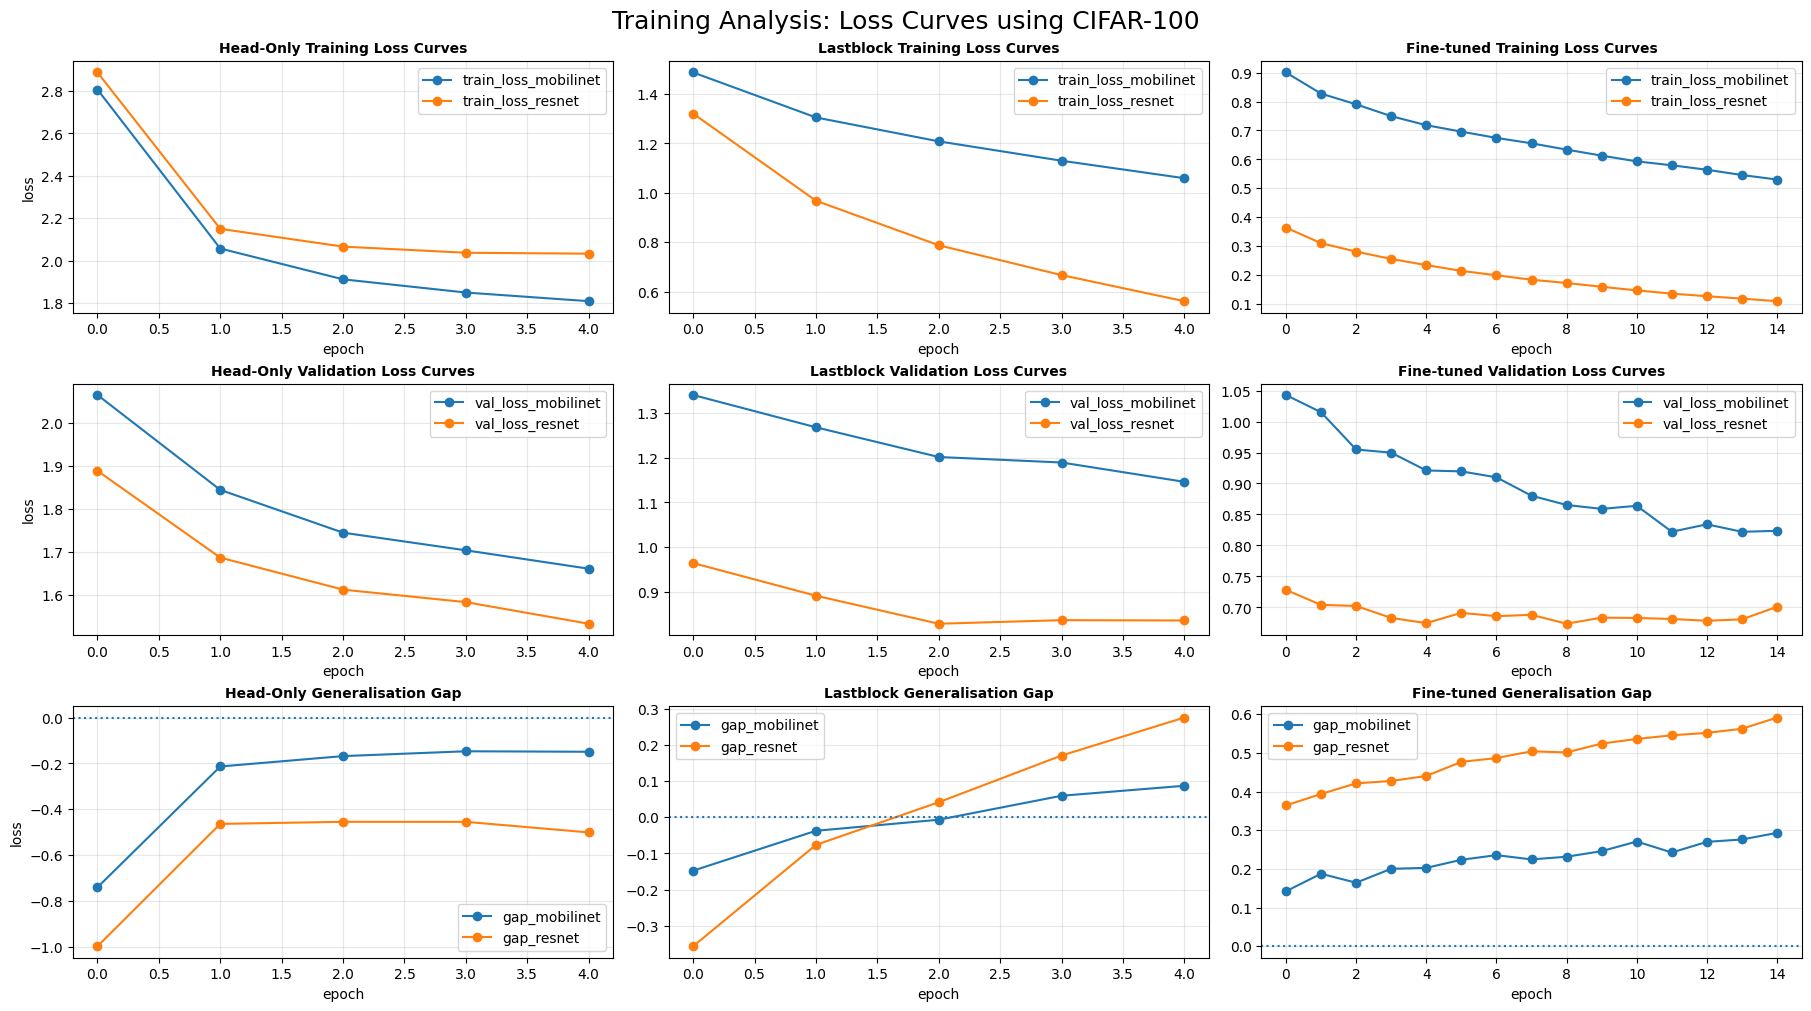

In [57]:
fig, ax = plt.subplots(3, 3, figsize=(18, 10), layout="constrained") # additional parameter 'layout' automatically adjusts subplots -> not to have overlaps
fig.suptitle(f"Training Analysis: Loss Curves using {dataset_name}", fontsize=18)

list_strategies=['Head-Only','Lastblock','Fine-tuned']
#to fill column by column
for i,(df_mobilinet, df_resnet) in enumerate(zip ([mobilinet_head,mobilinet_lastblock,mobilinet_finetuned],[resnet_head,resnet_lastblock,resnet_finetuned])):

    axis_labels=['epoch','loss'] if i==0 else  ['epoch','']  # to have loss label in y axis only in head column
    
    plot_training_analytics([df_mobilinet,df_resnet], ax[0,i], 'train_loss', title=f'{list_strategies[i]} Training Loss Curves', labels=['train_loss_mobilinet','train_loss_resnet'], axis_labels=axis_labels)
    plot_training_analytics([df_mobilinet,df_resnet], ax[1,i], 'val_loss', title=f'{list_strategies[i]} Validation Loss Curves', labels=['val_loss_mobilinet','val_loss_resnet'], axis_labels=axis_labels)
    plot_training_analytics([df_mobilinet,df_resnet], ax[2,i], 'gap', title=f'{list_strategies[i]} Generalisation Gap', labels=['gap_mobilinet','gap_resnet'], axis_labels=axis_labels)
    ax[2,i].axhline(y=0,linestyle=':') # add line y=0

Let's analyse the loss curves by training strategy:

> **Head-Only Training :** 
<br>Both models start with significantly higher loss values (> 2.0) compared to CIFAR-10 -> The pre-trained features struggle to distinguish between 100 classes without deeper adaptation.
<br>|__ Validation Loss < Training Loss -> **Severe Underfitting**. The large negative gap (especially for ResNet) indicates the models are not learning the training data effectively due to frozen weights.

> **Lastblock Training :** 
<br>ResNet-18 (orange) adapts much faster than MobileNet, dropping validation loss below 0.9 while MobileNet stays above 1.1.
<br>|__ Generalisation gap crosses zero (ResNet around epoch 1.5, MobileNet around epoch 2) -> Ideally, training should stop shortly after this point or regularization should be increased.

> **Full Fine-Tuning Training :** 
<br>We see a dramatic split between training and validation performance, highlighting the difficulty of CIFAR-100.
<br>|__ Validation Loss >>> Training Loss -> **Significant Overfitting**. ResNet-18 shows a massive generalization gap (~0.6), indicating it has "memorized" the training set (training loss near 0.1) but fails to generalize well. MobileNet has a smaller gap (~0.3) but higher overall loss, suggesting it lacks the capacity to memorize as intensely as ResNet.

### Accuracy curves comparison

Below is plotting of accuracy curves of each trasfer learning strategy for each model architecture.

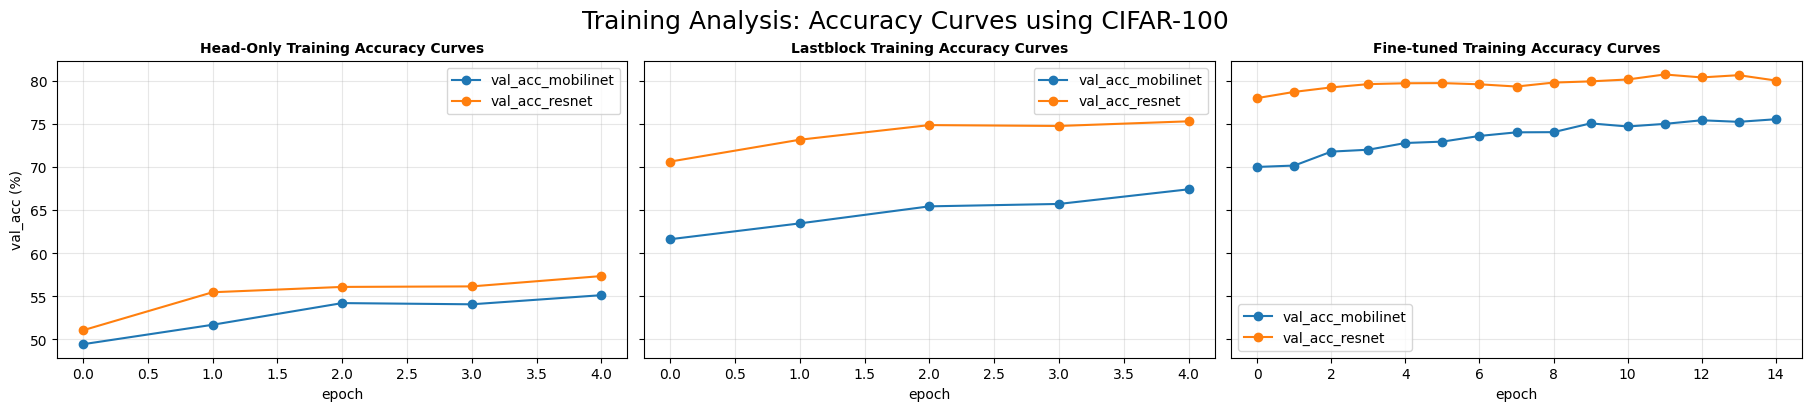

In [58]:
fig, ax = plt.subplots(1, 3, figsize=(18, 4), sharey=True,layout="constrained") # additional parameter 'layout' automatically adjusts subplots -> not to have overlaps
fig.suptitle(f"Training Analysis: Accuracy Curves using {dataset_name}", fontsize=18)

list_strategies=['Head-Only','Lastblock','Fine-tuned']
for i,(df_mobilinet, df_resnet) in enumerate(zip ([mobilinet_head,mobilinet_lastblock,mobilinet_finetuned],[resnet_head,resnet_lastblock,resnet_finetuned])):
    axis_labels=['epoch','val_acc (%)'] if i==0 else  ['epoch','']  # to have loss label in y axis only in head column
    
    df_mobilinet['val_acc_percent'] = df_mobilinet['val_acc'] * 100
    df_resnet['val_acc_percent'] = df_resnet['val_acc'] * 100

    plot_training_analytics([df_mobilinet, df_resnet], ax[i], 'val_acc_percent', title=f'{list_strategies[i]} Training Accuracy Curves', labels=['val_acc_mobilinet','val_acc_resnet'], axis_labels=axis_labels)

> Generally we can easily spot that ResNet-18 consistently achieves higher validation accuracy across all three strategies, maintaining a steady lead of roughly 5-8% over MobileNet V2.

> For Lastblock strategy, the "jump" is less dramatic than in CIFAR-10 due to the dataset's higher complexity. ResNet climbs steadily to ~75% accuracy, proving its deep features are robust even for 100 classes. MobileNet lags behind at ~67%, indicating that its lightweight architecture struggles more with the finer class distinctions when the backbone is frozen.

> **Peak performance** -> for both models, the peak is reached during the Fine-tuning strategy, but the scores are lower than CIFAR-10. ResNet tops out at ~80% (vs 95% in CIFAR-10) and MobileNet plateaus around ~75%, reflecting the significantly harder challenge of classifying 100 categories.

### Max Accuracy

We gather the best performing metrics from every model and strategy to create a final comparison table.

In [59]:
data_list = []
for i,(df_mobilinet, df_resnet) in enumerate(zip ([mobilinet_head,mobilinet_lastblock,mobilinet_finetuned],[resnet_head,resnet_lastblock,resnet_finetuned])):
    lr = 0.001 if list_strategies[i]== 'Head-Only' else 0.0001 if  list_strategies[i]== 'Lastblock' else 0.00001 #from train_cifar_10.py file
    data_list.append({'training_strategy':list_strategies[i], 'model': 'MobiliNet V2','max_val_acc':df_mobilinet['val_acc_percent'].max(),'epochs':len(df_mobilinet),'initial_weights':'Imagenet', 'data':dataset_name, 'learning_rate': lr})

    data_list.append({'training_strategy': list_strategies[i], 'model': 'ResNet-18','max_val_acc':df_resnet['val_acc_percent'].max(),'epochs':len(df_resnet),'initial_weights':'Imagenet','data':dataset_name, 'learning_rate': lr})

df_max_acc = pd.DataFrame(data_list)
df_max_acc

,training_strategy,model,max_val_acc,epochs,initial_weights,data,learning_rate
0,Head-Only,MobiliNet V2,55.14,5,Imagenet,CIFAR-100,0.00100
1,Head-Only,ResNet-18,57.36,5,Imagenet,CIFAR-100,0.00100
2,Lastblock,MobiliNet V2,67.44,5,Imagenet,CIFAR-100,0.00010
3,Lastblock,ResNet-18,75.34,5,Imagenet,CIFAR-100,0.00010
4,Fine-tuned,MobiliNet V2,75.58,15,Imagenet,CIFAR-100,0.00001
5,Fine-tuned,ResNet-18,80.78,15,Imagenet,CIFAR-100,0.00001


Below is bar plot of the maximum accuracy.

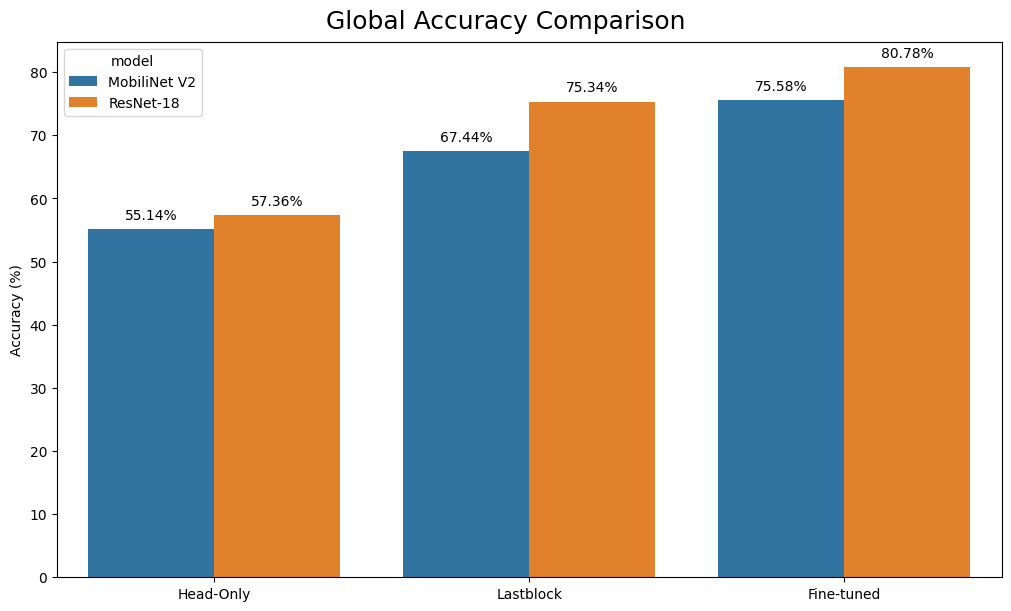

In [60]:
plt.figure(figsize=(10, 6), layout="constrained")
plt.suptitle("Global Accuracy Comparison", fontsize=18)

ax = sns.barplot(data=df_max_acc, x="training_strategy", y="max_val_acc", hue="model")

for container in ax.containers:
    ax.bar_label(container, fmt='%.2f%%', padding=5) # add percentage on top of bars
    
plt.ylabel("Accuracy (%)")
plt.xlabel('')
plt.show()

## Part II: Global Performance Comparison (MobileNet vs. ResNet)

First let's analyse global metrics for ResNet-18 architecture.

In [61]:
resnet_report = classification_report(resnet_y_true, resnet_y_pred, output_dict=True)

print(f"Global Accuracy     | {resnet_report['accuracy'] * 100:.2f}% -> % of total correct predictions")
print(f"Macro Precision     | {resnet_report['macro avg']['precision'] * 100:.2f}% -> average precision per class (all classes are treated equally)")
print(f"Weighted Precision  | {resnet_report['weighted avg']['precision'] * 100:.2f}% -> average precision, but weighted per class size (useful if data is imbalance)")
print(f"Macro F1-Score      | {resnet_report['macro avg']['f1-score'] * 100:.2f}% -> harmonic mean of precision and recall")
print(f"Weighted F1-Score   | {resnet_report['weighted avg']['f1-score'] * 100:.2f}% -> F1-Score weighted by true instances")

Global Accuracy     | 80.22% -> % of total correct predictions
Macro Precision     | 80.48% -> average precision per class (all classes are treated equally)
Weighted Precision  | 80.48% -> average precision, but weighted per class size (useful if data is imbalance)
Macro F1-Score      | 80.22% -> harmonic mean of precision and recall
Weighted F1-Score   | 80.22% -> F1-Score weighted by true instances


Collect report into the DataFrame.

In [62]:
df_resnet_report= pd.DataFrame(resnet_report).transpose().drop(
        ['macro avg', 'weighted avg', 'accuracy'], 
        axis=0, 
        errors='ignore'
    )
df_resnet_report['model'] = 'resnet'
df_resnet_report.head(5)

,precision,recall,f1-score,support,model
0,0.950000,0.95,0.950000,100.0,resnet
1,0.892157,0.91,0.900990,100.0,resnet
2,0.657407,0.71,0.682692,100.0,resnet
3,0.669725,0.73,0.698565,100.0,resnet
4,0.657143,0.69,0.673171,100.0,resnet


Same actions for MobiliNet V2 architecture.

In [63]:
mobilinet_report = classification_report(mobilinet_y_true, mobilinet_y_pred, output_dict=True)

print(f"Global Accuracy     | {mobilinet_report['accuracy'] * 100:.2f}% -> % of total correct predictions")
print(f"Macro Precision     | {mobilinet_report['macro avg']['precision'] * 100:.2f}% -> average precision per class (all classes are treated equally)")
print(f"Weighted Precision  | {mobilinet_report['weighted avg']['precision'] * 100:.2f}% -> average precision, but weighted per class size (useful if data is imbalance)")
print(f"Macro F1-Score      | {mobilinet_report['macro avg']['f1-score'] * 100:.2f}% -> harmonic mean of precision and recall")
print(f"Weighted F1-Score   | {mobilinet_report['weighted avg']['f1-score'] * 100:.2f}% -> F1-Score weighted by true instances")

Global Accuracy     | 75.89% -> % of total correct predictions
Macro Precision     | 76.07% -> average precision per class (all classes are treated equally)
Weighted Precision  | 76.07% -> average precision, but weighted per class size (useful if data is imbalance)
Macro F1-Score      | 75.87% -> harmonic mean of precision and recall
Weighted F1-Score   | 75.87% -> F1-Score weighted by true instances


In [64]:
df_mobilinet_report= pd.DataFrame(mobilinet_report).transpose().drop(
        ['macro avg', 'weighted avg', 'accuracy'], 
        axis=0, 
        errors='ignore'
    )
df_mobilinet_report['model'] = 'mobilinet'
df_mobilinet_report.head()

,precision,recall,f1-score,support,model
0,0.948454,0.92,0.934010,100.0,mobilinet
1,0.864078,0.89,0.876847,100.0,mobilinet
2,0.706522,0.65,0.677083,100.0,mobilinet
3,0.715909,0.63,0.670213,100.0,mobilinet
4,0.535714,0.60,0.566038,100.0,mobilinet


We merge the classification reports for both architectures into a single DataFrame. This unified format allows for a direct, side-by-side comparison of per-class performance (Precision, Recall, F1-Score).

In [65]:
df_class_report =pd.concat([df_mobilinet_report, df_resnet_report],axis=0).reset_index().rename(columns={'index': 'class_label'})

cols = ['precision', 'recall', 'f1-score']
df_class_report[cols] = (df_class_report[cols] * 100).round(2) # round
df_class_report['support']=df_class_report['support'].fillna(0).astype(int) # make int from float
df_class_report['class_label'] = df_class_report['class_label'].astype(int).apply(lambda x: class_labels[x])

df_class_report.sort_values(by='class_label')

,class_label,precision,recall,f1-score,support,model
0,apple,94.85,92.0,93.40,100,mobilinet
100,apple,95.00,95.0,95.00,100,resnet
1,aquarium_fish,86.41,89.0,87.68,100,mobilinet
101,aquarium_fish,89.22,91.0,90.10,100,resnet
2,baby,70.65,65.0,67.71,100,mobilinet
...,...,...,...,...,...,...
97,wolf,80.00,76.0,77.95,100,mobilinet
198,woman,57.02,69.0,62.44,100,resnet
98,woman,61.05,58.0,59.49,100,mobilinet
99,worm,76.85,83.0,79.81,100,mobilinet


Define function for plotting analytics of metrics per class.

In [66]:
def plot_class_analytics(df, ax, metric:str, interval=None, title:str=None,axis_labels=None):  
    """
    Args:
        df: single DataFrame
        ax: matplotlib axis
        *metrics: column names to plot
        interval: [min, max] to enforce y-axis limits
        title: main title for the subplot
        axis_labels: [x_label, y_label]
    Returns:
        None
    """
    ax = sns.barplot(data=df, x="class_label", y=metric, hue="model", ax=ax, ) #palette='viridis'
    ax.tick_params(axis='x', rotation=90, labelsize=6)
    if axis_labels: 
        ax.set_xlabel(axis_labels[0])
        ax.set_ylabel(axis_labels[1])

    if title: ax.set_title(title)
    if interval: ax.set_ylim(interval[0], interval[1])
    ax.grid(alpha=0.2, axis='y')

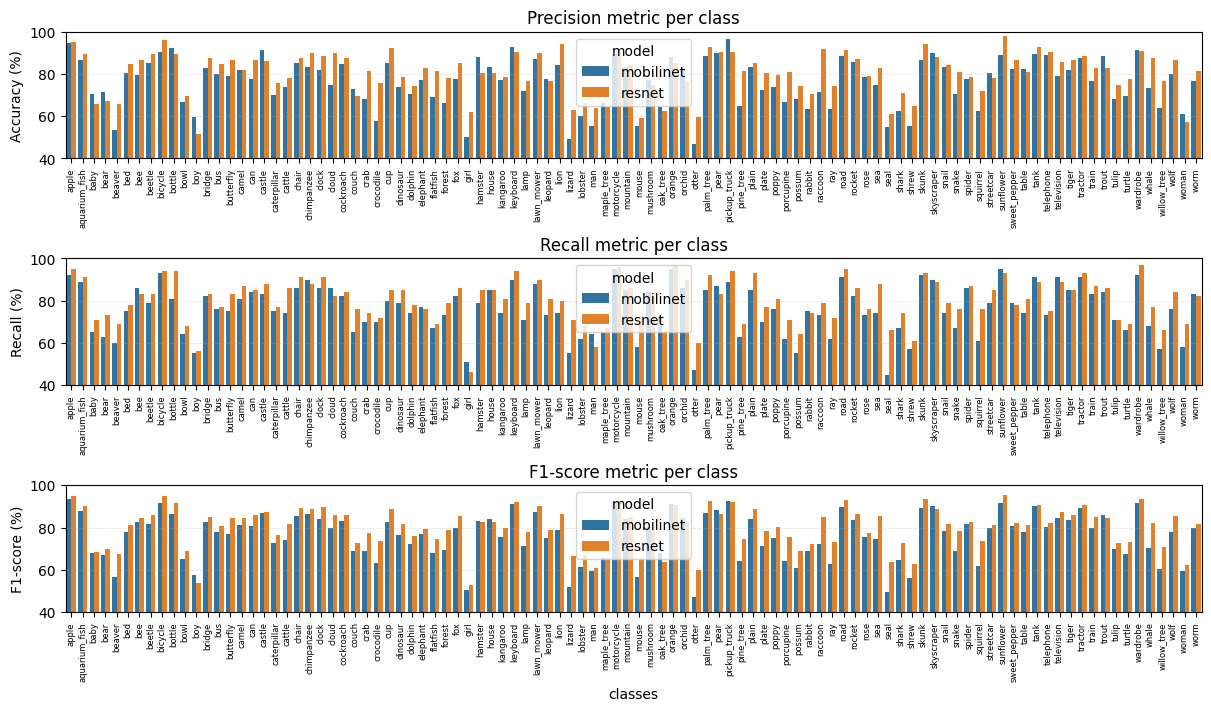

In [67]:
fig, ax = plt.subplots(3,1,figsize=(12, 7), layout="constrained")
plot_class_analytics(df_class_report,ax[0],'precision', title='Precision metric per class', interval=[40,100], axis_labels=['','Accuracy (%)'])
plot_class_analytics(df_class_report,ax[1],'recall', title='Recall metric per class', interval=[40,100], axis_labels=['','Recall (%)'])
plot_class_analytics(df_class_report,ax[2],'f1-score', title='F1-score metric per class', interval=[40,100], axis_labels=['classes','F1-score (%)'])
plt.show()

## Part III: Micro-Level Analysis (Confusion Matrices)

Before looking at the complex 10x10 matrix, we break the problem down into **10 binary classification problems**.

For each class (for example for 'Airplane' class):
* **TP:** Correctly identified Airplanes.
* **TN:** Correctly identified "Not Airplanes" (everything else).
* **FP:** "Not Airplanes" falsely classified as Airplanes (Ghost detections).
* **FN:** Airplanes missed by the model (Missed detections).

<br>To conclude matrics will look like that:
$$\begin{bmatrix}
\text{True Positives (TP)} & \text{False Positives (FP)} \\
\text{False Negatives (FN)} & \text{True Negatives (TN)}
\end{bmatrix}$$

Below is mapping the numerical class indices (e.g., 0, 1) to their corresponding string names (e.g., 'airplane', 'automobile') to ensure that downstream visualizations and confusion matrices are immediately interpretable without referencing a lookup table.

In [68]:
if type(resnet_y_true[0]) != str:
    #make y_true and y_pred to have str classes names not numbers
    resnet_y_true = [class_labels[i] for i in resnet_y_true]
    resnet_y_pred = [class_labels[i] for i in resnet_y_pred]

    #make y_true and y_pred to have str classes names not numbers
    mobilinet_y_true = [class_labels[i] for i in mobilinet_y_true]
    mobilinet_y_pred = [class_labels[i] for i in mobilinet_y_pred]
else: print('Already class labels instead of IDs')

Function below is to prints the binary confusion matrices for the first 'n' classes.

In [69]:
def print_conf_matr_by_classes(per_class_confusion_matrices, n:int, labels=None):
    print(f'>>> Comparison of Confusion Matrices for {n} classes:\n')

    if isinstance(per_class_confusion_matrices, list):
        for i in range(n):
            print(f"---> Class: {class_labels[i]} <---")
            #print header
            header = " | ".join(f"{label:<20}" for label in labels)
            print(header)

            #convert each matrix row to string lines
            rows = [str(matrix[i]).split("\n") for matrix in per_class_confusion_matrices] # [['[[8957   43]', ' [  33  967]]'] <- for resnet, ['[[8944   56]', ' [  58  942]]'] <- for mobilinet]

            #print rows
            for row_parts in zip(*rows): #zip groups '[[8957   43]' and '[[8944   56]' e.g.
                print(" | ".join(f"{part:<20}" for part in row_parts))
            print() #between classes
    else:
        for i in range(n):
            print(f"---> Class: {class_labels[i]} <---")
            print(per_class_confusion_matrices[i],'\n')


In [70]:
# calculates confusion matrix for each class
resnet_per_class_confusion_matrices = multilabel_confusion_matrix(resnet_y_true, resnet_y_pred, labels=class_labels)
mobilinet_per_class_confusion_matrices = multilabel_confusion_matrix(mobilinet_y_true, mobilinet_y_pred, labels=class_labels)

resnet_per_class_confusion_matrices[0]

array([[9895,    5],
       [   5,   95]])

In [71]:
print_conf_matr_by_classes([resnet_per_class_confusion_matrices, mobilinet_per_class_confusion_matrices], 3, labels=['ResNet', 'MobiliNet'])

>>> Comparison of Confusion Matrices for 3 classes:

---> Class: apple <---
ResNet               | MobiliNet           
[[9895    5]         | [[9895    5]        
 [   5   95]]        |  [   8   92]]       

---> Class: aquarium_fish <---
ResNet               | MobiliNet           
[[9889   11]         | [[9886   14]        
 [   9   91]]        |  [  11   89]]       

---> Class: baby <---
ResNet               | MobiliNet           
[[9863   37]         | [[9873   27]        
 [  29   71]]        |  [  35   65]]       



Also to analyse mistakes we can use confusion matrix for multiclass classification. In our case it is 100x100 matrix for CIFAR-100, where **Rows represent the True Classes** and **Columns represent the Predicted Classes**.

> The Diagonal -> these are the Correct Predictions (True Positives)

> The Off-Diagonal numbers -> mistakes

![Confusion Matrix for Multiclass Classification](https://miro.medium.com/v2/resize:fit:622/format:webp/1*Bmph46Rhl_z0w_Im_cRs3g.png)

In [72]:
mobilinet_overall_confusion_matrix = confusion_matrix(mobilinet_y_true, mobilinet_y_pred)
mobilinet_overall_confusion_matrix


array([[92,  0,  0, ...,  0,  0,  0],
       [ 0, 89,  0, ...,  0,  0,  0],
       [ 0,  0, 65, ...,  0,  2,  0],
       ...,
       [ 0,  0,  0, ..., 76,  0,  0],
       [ 0,  1,  2, ...,  0, 58,  0],
       [ 0,  0,  0, ...,  0,  0, 83]])

In [73]:
resnet_overall_confusion_matrix = confusion_matrix(resnet_y_true, resnet_y_pred)
resnet_overall_confusion_matrix

array([[95,  0,  0, ...,  0,  0,  0],
       [ 0, 91,  0, ...,  0,  0,  0],
       [ 0,  0, 71, ...,  0,  5,  0],
       ...,
       [ 0,  0,  0, ..., 84,  0,  1],
       [ 0,  0,  1, ...,  0, 69,  0],
       [ 0,  0,  0, ...,  0,  0, 82]])

Summarise two confusion matrices per model architecture.

In [74]:
print(f'Correctly classified using MobiliNet: {mobilinet_overall_confusion_matrix.diagonal().sum()}')
print(f'Correctly classified using ResNet: {resnet_overall_confusion_matrix.diagonal().sum()}')

Correctly classified using MobiliNet: 7589
Correctly classified using ResNet: 8022


Helper function to analyse mistakes during model classification per class.

In [75]:
def print_analytics_of_conf_matrix(y_true, y_pred, cm, target_class):
    """
    Args:
        - y_true: list of actual, correct labels
        - y_pred: list of model's predictions
        - cm: pre-calculated confusion matrix
        - target_class: which class to analyse (can be 'str' label or ID)
    """
    #to handle id and str label
    if isinstance(target_class, str):
        target_class_id, target_class_name = class_labels.index(target_class), target_class
    else:
        target_class_id, target_class_name = target_class, class_labels[target_class]

    print(f'>>> Confusion Matrix for: {target_class_name} (ID={target_class_id})')
    print(cm[target_class_id]) 
    
    indices = [i for i, x in enumerate(y_true) if x == target_class_name]
    predictions_for_target = [y_pred[i] for i in indices]
    counts = Counter(predictions_for_target) #count

    print(f"\nWhen true image was '{target_class_name}', model predicted:")
    
    for pred, count in counts.most_common():
        pred_name = class_labels[pred] if isinstance(pred, int) else pred
        
        pct = (count / len(indices)) * 100
        print(f" - {pred_name:<12}-> {count} times ({pct:.1f}%)")
    print("-" * 40)

In [76]:
print_analytics_of_conf_matrix(resnet_y_true,resnet_y_pred,resnet_per_class_confusion_matrices,'girl')

>>> Confusion Matrix for: girl (ID=35)
[[9872   28]
 [  54   46]]

When true image was 'girl', model predicted:
 - girl        -> 46 times (46.0%)
 - woman       -> 20 times (20.0%)
 - baby        -> 13 times (13.0%)
 - boy         -> 10 times (10.0%)
 - man         -> 5 times (5.0%)
 - camel       -> 1 times (1.0%)
 - possum      -> 1 times (1.0%)
 - lobster     -> 1 times (1.0%)
 - table       -> 1 times (1.0%)
 - otter       -> 1 times (1.0%)
 - fox         -> 1 times (1.0%)
----------------------------------------


Following function prints the heatmap of confusion matrix.

In [77]:
def conf_matrix_heatmap(cm, ax,dots_to_plot=None, title:str=None,class_labels=None):  
   
    if title: ax.set_title(title, fontweight='bold', fontsize=10)
    sns.heatmap(cm, 
                annot=False, # if true numbers will appear
                cmap='Blues', # color 'Blues' or 'viridis' 
                vmax=20,
                cbar_kws={'label': 'Number of Images'},
                ax=ax
                ) 
    if dots_to_plot:
        x_coords = []
        y_coords = []

        for true_id, pred_id in dots_to_plot:
            x_coords.append(pred_id + 0.5)  # -> to be in middle of square
            y_coords.append(true_id + 0.5)
            
            print(f"Marking: {class_labels[true_id]} (ID {true_id}) -> {class_labels[pred_id]} (ID {pred_id})")
    
        ax.scatter(x_coords, y_coords, color='red', marker='o', linewidth=2)  
    
    ax.set_ylabel('True Class ID')
    ax.set_xlabel('Predicted Class ID')

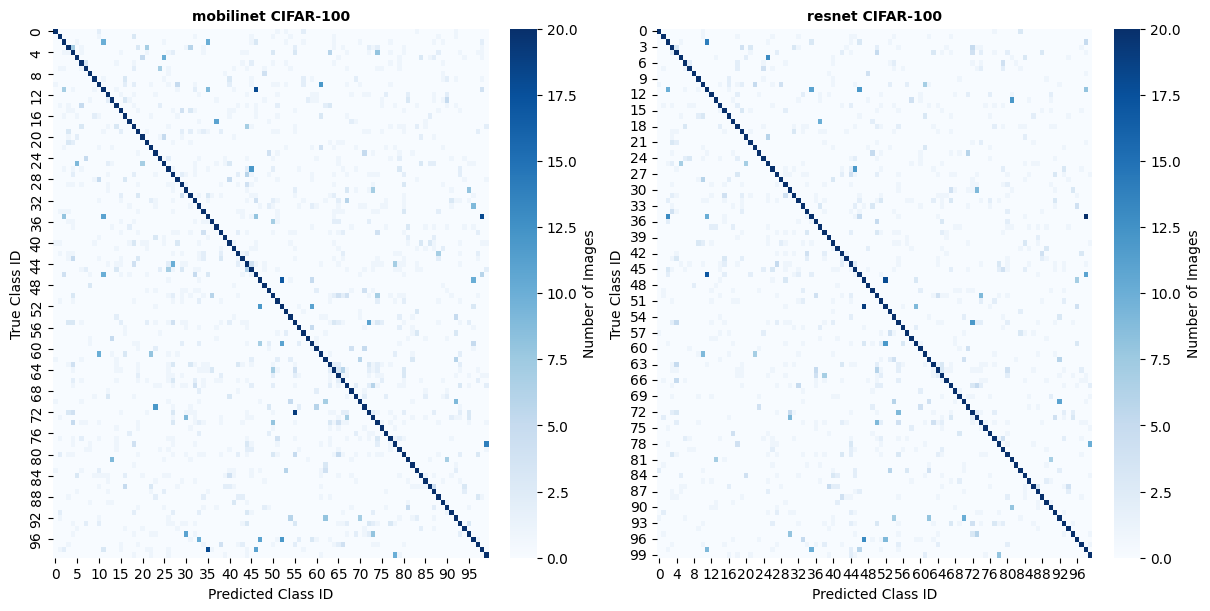

In [78]:
fig, ax = plt.subplots(1,2,figsize=(12, 6), layout="constrained")
conf_matrix_heatmap(mobilinet_overall_confusion_matrix,ax[0],title=f'mobilinet {dataset_name}')
conf_matrix_heatmap(resnet_overall_confusion_matrix,ax[1],title=f'resnet {dataset_name}')

This function parses the confusion matrix to identify and rank the most frequent misclassifications. It ignores correct predictions (the diagonal) to focus purely on errors, returning the top $N$ pairs where the model confused Class A for Class B.

In [79]:
def get_top_confusions(cm_, class_names, top_n=10):
    cm = cm_.copy()
    np.fill_diagonal(cm, 0) # Zero out correct predictions (diagonal) to find errors
    
    pairs = []
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            if cm[i, j] > 0:
                pairs.append((i, j, cm[i, j]))
    
    # Sort in descending order
    pairs.sort(key=lambda x: x[2], reverse=True)
    
    print(f">>> Top {top_n} Confusions <<<")
    for i in range(min(top_n, len(pairs))):
        true_idx, pred_idx, count = pairs[i]
        
        t_name = class_names[true_idx] if class_names else str(true_idx)
        p_name = class_names[pred_idx] if class_names else str(pred_idx)
        
        print(f"True: {class_labels.index(t_name)} - {t_name:<15} Predicted: {class_labels.index(p_name)} - {p_name:<15} Count: {count}")
        
get_top_confusions(resnet_overall_confusion_matrix, class_labels)

>>> Top 10 Confusions <<<
True: 35 - girl            Predicted: 98 - woman           Count: 20
True: 52 - oak_tree        Predicted: 47 - maple_tree      Count: 19
True: 47 - maple_tree      Predicted: 52 - oak_tree        Count: 18
True: 46 - man             Predicted: 11 - boy             Count: 17
True: 2 - baby            Predicted: 11 - boy             Count: 14
True: 5 - bed             Predicted: 25 - couch           Count: 13
True: 35 - girl            Predicted: 2 - baby            Count: 13
True: 96 - willow_tree     Predicted: 47 - maple_tree      Count: 13
True: 11 - boy             Predicted: 46 - man             Count: 12
True: 13 - bus             Predicted: 81 - streetcar       Count: 12


Below we can see that top 2 confusion cases on confusion matrices

* True: 3 - cat             Predicted: 5 - dog             Count: 89
* True: 5 - dog             Predicted: 3 - cat             Count: 40

Marking: girl (ID 35) -> woman (ID 98)
Marking: oak_tree (ID 52) -> maple_tree (ID 47)
Marking: maple_tree (ID 47) -> oak_tree (ID 52)
Marking: man (ID 46) -> boy (ID 11)
Marking: girl (ID 35) -> woman (ID 98)
Marking: oak_tree (ID 52) -> maple_tree (ID 47)
Marking: maple_tree (ID 47) -> oak_tree (ID 52)
Marking: man (ID 46) -> boy (ID 11)


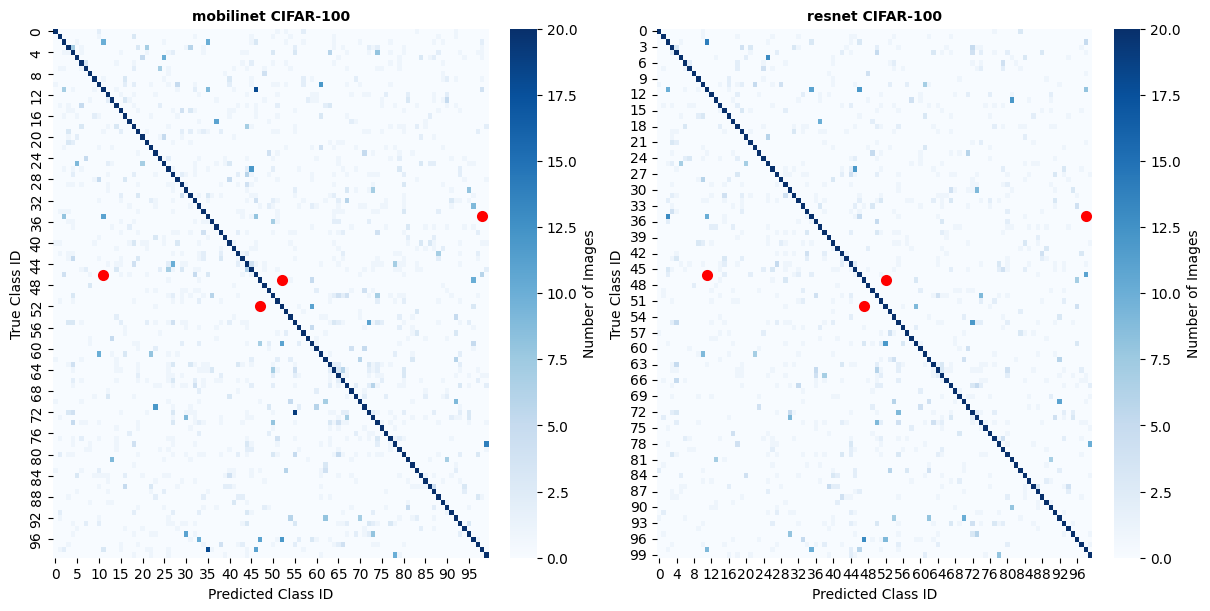

In [80]:
fig, ax = plt.subplots(1,2,figsize=(12, 6), layout="constrained")
conf_pairs = [[35,98], [52,47], [47, 52], [46,11]]
conf_matrix_heatmap(mobilinet_overall_confusion_matrix, ax[0], title=f'mobilinet {dataset_name}', dots_to_plot=conf_pairs,class_labels=class_labels)
conf_matrix_heatmap(resnet_overall_confusion_matrix, ax[1], title=f'resnet {dataset_name}', dots_to_plot=conf_pairs,class_labels=class_labels)

For graph above to understand how class ID relates to class labels.

In [81]:
for i,j in enumerate(class_labels):
    print(f'{i} - {j}'if i==0 else  f', {i} - {j}', end='')

0 - apple, 1 - aquarium_fish, 2 - baby, 3 - bear, 4 - beaver, 5 - bed, 6 - bee, 7 - beetle, 8 - bicycle, 9 - bottle, 10 - bowl, 11 - boy, 12 - bridge, 13 - bus, 14 - butterfly, 15 - camel, 16 - can, 17 - castle, 18 - caterpillar, 19 - cattle, 20 - chair, 21 - chimpanzee, 22 - clock, 23 - cloud, 24 - cockroach, 25 - couch, 26 - crab, 27 - crocodile, 28 - cup, 29 - dinosaur, 30 - dolphin, 31 - elephant, 32 - flatfish, 33 - forest, 34 - fox, 35 - girl, 36 - hamster, 37 - house, 38 - kangaroo, 39 - keyboard, 40 - lamp, 41 - lawn_mower, 42 - leopard, 43 - lion, 44 - lizard, 45 - lobster, 46 - man, 47 - maple_tree, 48 - motorcycle, 49 - mountain, 50 - mouse, 51 - mushroom, 52 - oak_tree, 53 - orange, 54 - orchid, 55 - otter, 56 - palm_tree, 57 - pear, 58 - pickup_truck, 59 - pine_tree, 60 - plain, 61 - plate, 62 - poppy, 63 - porcupine, 64 - possum, 65 - rabbit, 66 - raccoon, 67 - ray, 68 - road, 69 - rocket, 70 - rose, 71 - sea, 72 - seal, 73 - shark, 74 - shrew, 75 - skunk, 76 - skyscraper

## Part IV: CLass-Level Analysis

This function creates a grouped vertical bar chart to compare the performance metrics (Precision, Recall, and F1-Score) for a specific subset of classes (e.g., just "cat", "dog", and "deer"). It is useful for zooming in on your best or worst performing classes.

In [ ]:
def print_distribution_per_class_vert(df_classes, ax,list_classes, interval=None):
    # Filter rows
    sub = df_classes[df_classes['class_label'].isin(list_classes)].copy()
    sub = sub.sort_values(by='precision', ascending=False) # Optional: Descending looks better vertical

    # Melt data (same as before)
    df_melted = sub[['class_label', 'precision', 'recall', 'f1-score']].melt(
        id_vars='class_label',
        var_name='Metric',
        value_name='Score'
    )
    sns.barplot(
        data=df_melted,
        x='class_label',   # categorical
        y='Score',       # numerical
        hue='Metric',    
        palette='viridis',
        ax=ax,
    )

    for container in ax.containers:
        ax.bar_label(container, fmt='%.1f%%', padding=5) # add percentage on top of bars
    
    if interval: ax.set_ylim(interval[0], interval[1])
    ax.set_ylabel("%")
    ax.set_xlabel('class labels')

For worst 3 classes.

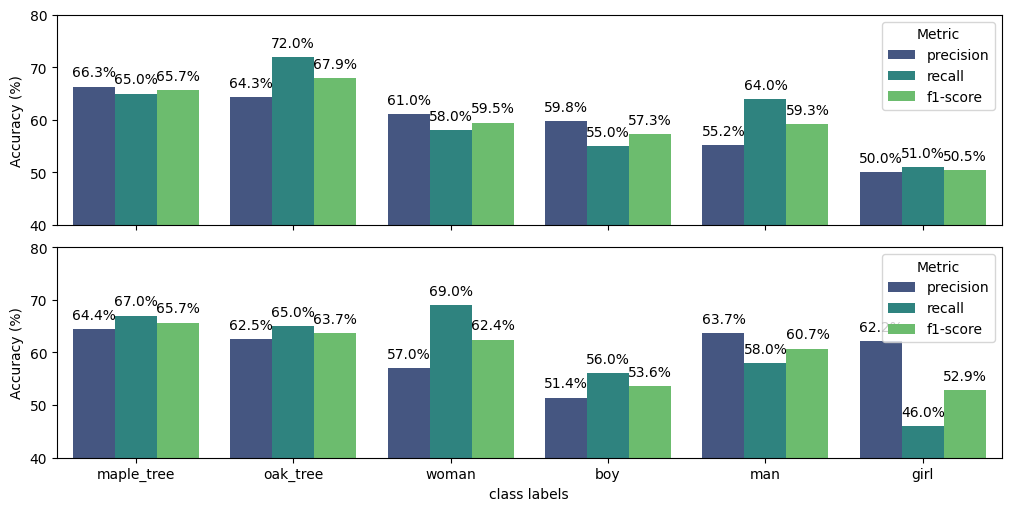

In [89]:
target_classes = ['girl', 'woman', 'man', 'boy', 'oak_tree', 'maple_tree']
fig, axes = plt.subplots(2, 1, figsize=(10, 5), sharex=True, layout="constrained")
print_distribution_per_class_vert(df_class_report[df_class_report['model']=='mobilinet'], axes[0], target_classes, interval=[40,80])
print_distribution_per_class_vert(df_class_report[df_class_report['model']=='resnet'], axes[1], target_classes, interval=[40,80])
plt.show()

For best 3 classes.

In [91]:
# target_classes = ['girl', 'woman', 'man', 'boy', 'oak_tree', 'maple_tree']
# fig, axes = plt.subplots(2, 1, figsize=(10, 5), sharex=True, layout="constrained")

# print_distribution_per_class_vert(df_class_report[df_class_report['model']=='mobilinet'], axes[0], target_classes, interval=[40,80])
# print_distribution_per_class_vert(df_class_report[df_class_report['model']=='resnet'], axes[1], target_classes, interval=[40,80])

## Part V: Qualitative Analysis (Visualizing Predictions)

In [85]:
def visualize_model_predictions(model, loader, class_labels,  target_class=None, num_images=5, device="cpu"):
    samples = []
    
    if target_class is not None:  target_class_id = class_labels.index(target_class) 
    
    model.eval()
    model.to(device)
    
    with torch.no_grad():
        for images, labels in loader: 
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            preds = outputs.argmax(dim=1)

            # Define filter
            if target_class:
                mask = (labels == target_class_id) & (preds != target_class_id)
            else:
                mask = torch.ones_like(labels, dtype=torch.bool)
            
            # Store matching images
            if mask.any():
                for img, t, p in zip(images[mask], labels[mask], preds[mask]):
                    samples.append((img.cpu(), t.item(), p.item()))
                    if len(samples) >= num_images: break
            
            if len(samples) >= num_images: break
        
    if not samples: return print("No images found.")

    
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    plt.figure(figsize=(10,5))
    for i in range(num_images) :
        img_tensor, true_id, pred_id = samples[i]
        plt.subplot(1,5,i+1)
        img = img_tensor.permute(1, 2, 0).numpy()
        img = (std * (img) + mean) 

        plt.axis("off")
        plt.title(f"True : {class_labels[true_id]}, Pred: {class_labels[pred_id]}",fontsize=10)
        plt.imshow(img)
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.3294117566347122..1.0000000236034394].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.011764687061309786..1.0000000236034394].


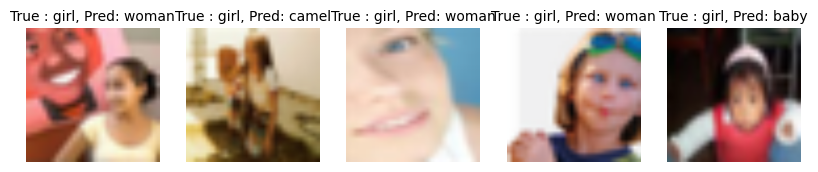

KeyboardInterrupt: 

In [92]:
visualize_model_predictions(resnet_model, test_loader,class_labels=class_labels,target_class='girl')
visualize_model_predictions(mobilinet_model, test_loader,class_labels=class_labels,target_class='girl')

## Part VI: Efficiency Analysis (Speed & Size)

In [ ]:
def get_efficiency_metrics(model, loader, device, model_path):
    model.eval()

    #model size
    size_mb = os.path.getsize(model_path) / (1024 * 1024)

    #total numb of parameters
    params = sum(p.numel() for p in model.parameters())
    
    num_samples = 0
    start_time = time.time()
    
    with torch.no_grad():
        for i, (images, labels) in enumerate(loader):
            images, labels = images.to(device), labels.to(device)
            num_samples += images.size(0)
            
            if i >= 10: break 
            
    end_time = time.time()
    avg_inference_time = (end_time - start_time) / num_samples

    print(f">>> Global Efficiency & Confidence Metrics")
    print(f"Model Size:       {size_mb:.2f} MB")
    print(f"Total Params:     {params:,}")
    print(f"Inference Time:   {avg_inference_time*1000:.2f} ms per image")
  
    return size_mb, params, avg_inference_time

_ = get_efficiency_metrics(resnet_model, test_loader, device, resnet_model_path)

>>> Global Efficiency & Confidence Metrics
Model Size:       42.73 MB
Total Params:     11,181,642
Inference Time:   24.47 ms per image


## Summary table

In [ ]:
#stylise df
cols = [
    'model',
    'initial_weights',
    'data',
    'training_strategy',
    'learning_rate',
    'max_val_acc',
    'epochs',
]

styled_df = df_max_acc[cols].style.format({
    'max_val_acc': '{:.2f}',
}).hide(axis="index")

#to save csv
df_max_acc[cols].to_csv(ROOT / 'project_report' / 'figures' / 'model_performance.csv', index=False, float_format='%.2f')

#to save png image of table
dfi.export(styled_df, ROOT / 'project_report' / 'figures' /'model_performance.png', table_conversion='matplotlib')
styled_df

model,initial_weights,data,training_strategy,max_val_acc,epochs
MobiliNet V2,Imagenet,CIFAR-10,Head-Only,76.58,5
ResNet-18,Imagenet,CIFAR-10,Head-Only,79.22,5
MobiliNet V2,Imagenet,CIFAR-10,Lastblock,87.74,5
ResNet-18,Imagenet,CIFAR-10,Lastblock,92.68,5
MobiliNet V2,Imagenet,CIFAR-10,Fine-tuned,93.56,15
ResNet-18,Imagenet,CIFAR-10,Fine-tuned,95.50,15


! For slides -> merge with CIFAR-10 and then save.